In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
import cv2
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
directory = "../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/"
fold_0 = pd.read_csv(os.path.join(directory, 'fold_0_data.txt'), sep='\t')
fold_1 = pd.read_csv(os.path.join(directory, 'fold_1_data.txt'),sep='\t')
fold_2 = pd.read_csv(os.path.join(directory, 'fold_2_data.txt'),sep='\t')
fold_3 = pd.read_csv(os.path.join(directory, 'fold_3_data.txt'),sep='\t')
fold_4 = pd.read_csv(os.path.join(directory, 'fold_4_data.txt'),sep='\t')
folds_arr = [fold_0, fold_1, fold_2, fold_3, fold_4]
folds_arr[0].head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [4]:
df = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
print('[+] length of the file:', len(df))
print('[+] unique values of Age:')
print(df.age.unique())
print('===================================================')
print('[+] Number of None Values in Age:')
print(df.age.isna().sum())
print('[+] unique values of Gender:')
print(df.gender.unique())
print('===================================================')
print('[+] Number of nan values in Gender:')
print(df.gender.isna().sum())

[+] length of the file: 19370
[+] unique values of Age:
['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' nan '(38, 48)' '35' '3' '55' '58' '22' '13' '45' '36'
 '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42' '46'
 '32']
[+] Number of None Values in Age:
748
[+] unique values of Gender:
['f' 'm' nan 'u']
[+] Number of nan values in Gender:
779


In [5]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict1 = {each[0]: each[1] for each in age_mapping}
age_mapping_dict2 = {'0-2':0, '4-6':1, '8-13':2, '15-20':3, '25-32':4, '38-43':5, '48-53':6, '60+':7}
gender_mapping_dict = {'f':0, 'm':1}

def generate_directory(row):
    return os.path.join(directory, 'faces', str(row['user_id']), f'coarse_tilt_aligned_face.{row["face_id"]}.{row["original_image"]}')

def process(df):
    df = df.dropna(subset=['gender','age'])
    df = df[df['gender'] != 'u']
    df['directory'] = df.apply(generate_directory, axis=1)
    df = df[['directory', 'age', 'gender']]
    df['gender'] = df['gender'].map(gender_mapping_dict)
    df['age'] = df['age'].map(age_mapping_dict1)
    df['age'] = df['age'].map(age_mapping_dict2)
    return df
folds_arr = [process(df) for df in folds_arr]
folds_arr[0].head()

,directory,age,gender
0,../input/adience-benchmark-gender-and-age-clas...,4,0
1,../input/adience-benchmark-gender-and-age-clas...,4,1
2,../input/adience-benchmark-gender-and-age-clas...,4,0
3,../input/adience-benchmark-gender-and-age-clas...,4,1
4,../input/adience-benchmark-gender-and-age-clas...,4,1


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)), # Same hyperparameter as the paper "Age and Gender Classification using Convolutional Neural Networks"
])

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx,0])
        img = self.transform(img).to(device)
        age = torch.tensor(self.df.iloc[idx,1]).to(device)
        gender = torch.tensor(self.df.iloc[idx,2]).to(device)
        return img, age, gender

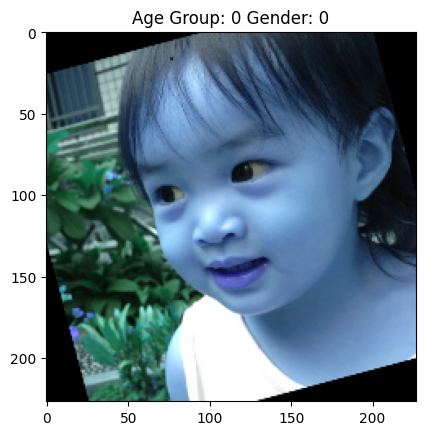

In [7]:
dataset_temp = CustomDataset(folds_arr[0], transform=transform)
dataloader_temp = DataLoader(dataset_temp, batch_size=16, shuffle=True)

data_iter = iter(dataloader_temp)
image, label_age, label_gender = next(data_iter)

plt.imshow(torch.Tensor.cpu(image[0].permute(1, 2, 0)))
plt.title(f'Age Group: {label_age[0]} Gender: {label_gender[0]}')
plt.show()

In [8]:
#DeformableCNN
# Build Model
class GenderAgeDeformableCNNModel(nn.Module):
    def __init__(self):
        super(GenderAgeDeformableCNNModel, self).__init__()
        self.dcn1 = DeformConv2d(3, 64, kernel_size=5, padding=1) # Add DCNN layer
        self.offsets1 = nn.Conv2d(3, 50, kernel_size=5, padding=1)
        self.p1 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.dcn2 = DeformConv2d(64, 64, kernel_size=5, padding=1) # Replace the CNN layer with DCNN layer
        self.offsets2 = nn.Conv2d(64, 50, kernel_size=5, padding=1)
        self.p2 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.dcn3 = DeformConv2d(64, 128, kernel_size=5, padding=1) # Replace the CNN layer with DCNN layer
        self.offsets3 = nn.Conv2d(64, 50, kernel_size=5, padding=1)
        self.p3 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(128 * 26 * 26, 256)
        self.d2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)
        self.outputGender = nn.Linear(128, 1)
        self.outputAge = nn.Linear(128, 8)
        
    def forward(self, x):
        offsets1 = self.offsets1(x)
        dcn1 = torch.relu(self.dcn1(x, offsets1))
        p1 = self.p1(dcn1)
        offsets2 = self.offsets2(p1)
        dcn2 = torch.relu(self.dcn2(p1, offsets2))
        p2 = self.p2(dcn2)
        offsets3 = self.offsets3(p2)
        dcn3 = torch.relu(self.dcn3(p2, offsets3))
        p3 = self.p3(dcn3)
        flatten = self.flatten(p3)
        d1 = torch.relu(self.d1(flatten))
        dropout1 = self.dropout(d1)
        d2 = torch.relu(self.d2(dropout1))
        dropout2 = self.dropout(d2)
        outGender = torch.sigmoid(self.outputGender(dropout2))
        outAge = torch.softmax(self.outputAge(dropout2), dim=1)
        return outGender, outAge

In [9]:
def train(model, train_dataloader, val_dataloader, num_epochs):
    train_gender_acc = []
    train_age_acc = []
    train_gender_loss = []
    train_age_loss = []
    val_gender_acc = []
    val_age_acc = []
    val_gender_loss = []
    val_age_loss = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model in training mode
        
        train_gender_losses = 0
        train_age_losses = 0
        output_gender_wrong = 0
        output_age_correct = 0
        
        num_batches = len(train_dataloader)
        size = len(train_dataloader.dataset)
        
        for i, data in enumerate(train_dataloader):
            inputs, labels_age, labels_gender = data
            labels_gender = labels_gender.unsqueeze(1).float()
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputGender, outputAge = model(inputs)
            
            # Compute the loss
            loss_gender = criterion_gender(outputGender, labels_gender)
            loss_age = criterion_age(outputAge, labels_age)
            total_loss = loss_gender + loss_age
            
            # Backpropagation and optimization
            total_loss.backward()
            optimizer.step()
            
            # Save statistics
            train_gender_losses += loss_gender.item()
            train_age_losses += loss_age.item()
            output_gender_wrong += torch.sum(torch.not_equal(outputGender > 0.5, labels_gender))
            output_age_correct += (outputAge.argmax(dim=1) == labels_age).sum().item()
        
        train_gender_losses /= num_batches
        train_age_losses /= num_batches
        train_gender_correct = (size - output_gender_wrong)/size # Calculate the accuracy for gender
        train_age_correct = output_age_correct/size
        
        train_gender_acc.append(train_gender_correct)
        train_gender_loss.append(train_gender_losses)
        train_age_acc.append(train_age_correct)
        train_age_loss.append(train_age_losses)
        

        output_gender_wrong = 0
        output_age_correct = 0
        val_age_losses = 0
        val_gender_losses = 0
        
        num_batches = len(val_dataloader)
        size = len(val_dataloader.dataset)
        
        for i, data in enumerate(val_dataloader):
            size = len(val_dataloader.dataset)
            inputs, labels_age, labels_gender = data
            labels_gender = labels_gender.unsqueeze(1).float()
            
            outputs_gender, outputs_age = model(inputs)
            loss_gender = criterion_gender(outputs_gender, labels_gender)
            loss_age = criterion_age(outputs_age, labels_age)
            loss = (loss_gender + loss_age)/2
            
            # Save statistics
            val_gender_losses += loss_gender.item()
            val_age_losses += loss_age.item()
            output_gender_wrong += torch.sum(torch.not_equal(outputs_gender > 0.5, labels_gender))
            output_age_correct += (outputs_age.argmax(dim=1) == labels_age).sum().item()
        
        val_gender_losses /= num_batches
        val_age_losses /= num_batches
        val_gender_correct = (size - output_gender_wrong)/size # Calculate the accuracy for gender
        val_age_correct = output_age_correct/size
        
        val_gender_acc.append(val_gender_correct)
        val_gender_loss.append(val_gender_losses)
        val_age_acc.append(val_age_correct)
        val_age_loss.append(val_age_losses)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy for Gender: {train_gender_correct:.4f}, Val Accuracy for Gender: {val_gender_correct:.4f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy for Age: {train_age_correct:.4f}, Val Accuracy for Age: {val_age_correct:.4f}')
        
    return train_gender_acc, train_age_acc, train_gender_loss, train_age_loss, val_gender_acc, val_age_acc, val_gender_loss, val_age_loss

In [10]:
batch_size = 64

val_dataset = CustomDataset(df=folds_arr[4], transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
folds_arr.pop(4)
df_temp = pd.concat(folds_arr, ignore_index=True)
train_dataset = CustomDataset(df=df_temp, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = GenderAgeDeformableCNNModel().to(device)
criterion_gender = nn.BCELoss()
criterion_age = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_gender_acc, train_age_acc, _, _, val_gender_acc, val_age_acc, _, _ = train(model, train_dataloader, val_dataloader, 5)

Epoch [1/5], Train Accuracy for Gender: 0.6264, Val Accuracy for Gender: 0.6964
Epoch [1/5], Train Accuracy for Age: 0.2954, Val Accuracy for Age: 0.3004
Epoch [2/5], Train Accuracy for Gender: 0.7502, Val Accuracy for Gender: 0.7443
Epoch [2/5], Train Accuracy for Age: 0.3328, Val Accuracy for Age: 0.3486
Epoch [3/5], Train Accuracy for Gender: 0.8192, Val Accuracy for Gender: 0.7855
Epoch [3/5], Train Accuracy for Age: 0.4027, Val Accuracy for Age: 0.3515
Epoch [4/5], Train Accuracy for Gender: 0.8535, Val Accuracy for Gender: 0.7747
Epoch [4/5], Train Accuracy for Age: 0.4508, Val Accuracy for Age: 0.3457
Epoch [5/5], Train Accuracy for Gender: 0.8869, Val Accuracy for Gender: 0.7916
Epoch [5/5], Train Accuracy for Age: 0.4860, Val Accuracy for Age: 0.3460


In [11]:
for i in range(len(train_gender_acc)):
    train_gender_acc[i] = torch.Tensor.cpu(train_gender_acc[i])
    val_gender_acc[i] = torch.Tensor.cpu(val_gender_acc[i])

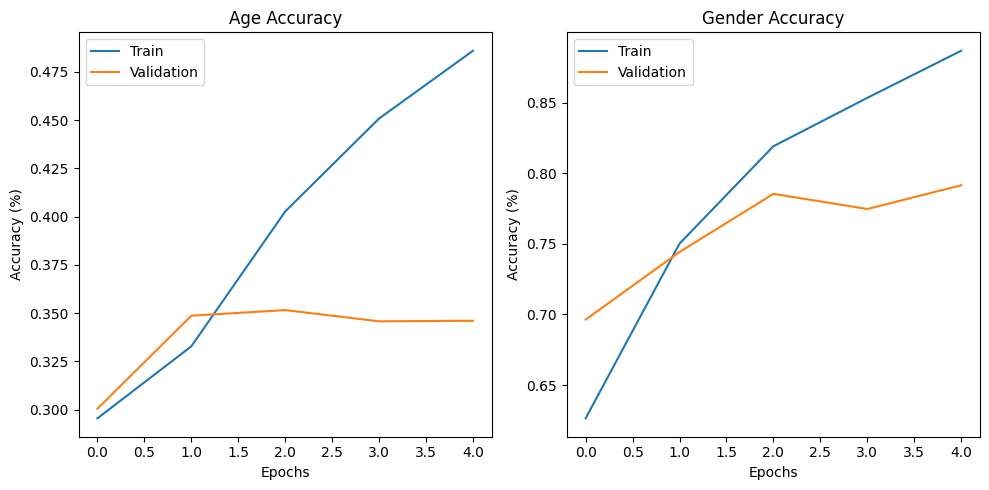

In [12]:
# Plot training and validation accuracy for age
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_age_acc, label='Train')
plt.plot(val_age_acc, label='Validation')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training and validation accuracy for gender
plt.subplot(1, 2, 2)
plt.plot(train_gender_acc, label='Train')
plt.plot(val_gender_acc, label='Validation')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
print("training accuracy for age:", train_age_acc)
print("training accuracy for gender:", train_gender_acc)
print("validation accuracy for age:", val_age_acc)
print("validation accuracy for gender:", val_gender_acc)

training accuracy for age: [0.29542371671307205, 0.3327621903334047, 0.402655814949668, 0.45084600556864424, 0.4859713000642536]
training accuracy for gender: [tensor(0.6264), tensor(0.7502), tensor(0.8192), tensor(0.8535), tensor(0.8869)]
validation accuracy for age: [0.30043541364296084, 0.3486211901306241, 0.35152394775036283, 0.34571843251088535, 0.34600870827285923]
validation accuracy for gender: [tensor(0.6964), tensor(0.7443), tensor(0.7855), tensor(0.7747), tensor(0.7916)]
